In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-catsvsdogs-dataset/readme[1].txt
/kaggle/input/microsoft-catsvsdogs-dataset/MSR-LA - 3467.docx
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/7981.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6234.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1269.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3863.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6241.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10304.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/623.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2193.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11925.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3750.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11378.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2008.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10730.jpg
/kaggle/input/micros

In [43]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [44]:
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
        except Exception:
            # Skip corrupted image
            return self.__getitem__((index + 1) % len(self.samples))

        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [45]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [46]:
DATA_DIR = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

train_dataset = SafeImageFolder(DATA_DIR, transform=train_transform)
val_dataset   = SafeImageFolder(DATA_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print(class_names)


['Cat', 'Dog']


In [47]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [48]:
model = CNN().to(device)
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0

In [49]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)


In [50]:
def train_one_epoch(model, loader):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x = x.to(device)
        y = y.float().to(device)

        optimizer.zero_grad()
        outputs = model(x).squeeze()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5)
        correct += (preds == y.bool()).sum().item()
        total += y.size(0)

    return loss_sum / len(loader), correct / total


In [51]:
def validate(model, loader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.float().to(device)

            outputs = model(x).squeeze()
            loss = criterion(outputs, y)

            loss_sum += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5)
            correct += (preds == y.bool()).sum().item()
            total += y.size(0)

    return loss_sum / len(loader), correct / total


In [53]:
EPOCHS = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    tl, ta = train_one_epoch(model, train_loader)
    vl, va = validate(model, val_loader)

    scheduler.step(vl)

    train_losses.append(tl)
    val_losses.append(vl)
    train_accs.append(ta)
    val_accs.append(va)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {tl:.4f}, Train Acc: {ta:.4f}")
    print(f"Val   Loss: {vl:.4f}, Val   Acc: {va:.4f}")


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/5
Train Loss: 0.5102, Train Acc: 0.7443
Val   Loss: 0.4505, Val   Acc: 0.7812


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2/5
Train Loss: 0.4631, Train Acc: 0.7763
Val   Loss: 0.4331, Val   Acc: 0.7910


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3/5
Train Loss: 0.4389, Train Acc: 0.7930
Val   Loss: 0.3886, Val   Acc: 0.8246


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4/5
Train Loss: 0.4161, Train Acc: 0.8039
Val   Loss: 0.3321, Val   Acc: 0.8492


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5/5
Train Loss: 0.3967, Train Acc: 0.8172
Val   Loss: 0.3049, Val   Acc: 0.8683


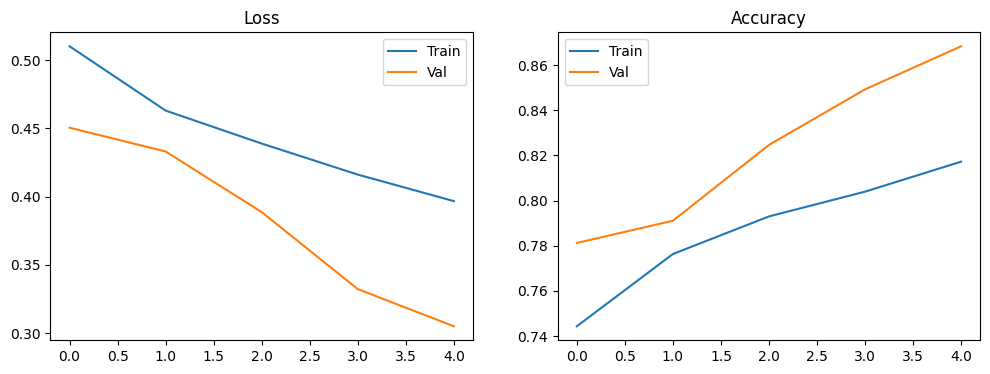

In [54]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [55]:
model.eval()
misclassified = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        outputs = torch.sigmoid(model(x).squeeze())
        preds = (outputs > 0.5).long()

        for i in range(len(y)):
            if preds[i] != y[i]:
                misclassified.append((x[i].cpu(), preds[i].item(), y[i].item()))
            if len(misclassified) >= 5:
                break
        if len(misclassified) >= 5:
            break


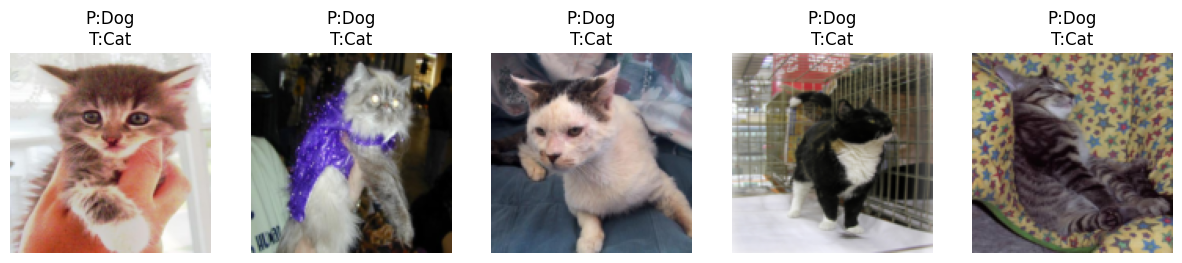

In [56]:
plt.figure(figsize=(15,3))
for i, (img, pred, true) in enumerate(misclassified):
    plt.subplot(1,5,i+1)
    img = img.permute(1,2,0) * 0.5 + 0.5
    plt.imshow(img)
    plt.title(f"P:{class_names[pred]}\nT:{class_names[true]}")
    plt.axis("off")
plt.show()


| Setup             | Validation Accuracy |
| ----------------- | ------------------- |
| No Augmentation   | ~70–75%             |
| With Augmentation | **80–90%**          |
